# 1. Visualisation

Dans ce notebook nous avons pour objectif de récupérer les données sur toutes les stations essences en France métropolitaine sur le site data.gouv. 
Ensuite nous analysons ces données pour faire ressortir caractéristiques les plus pertinentes pour la suite de notre projet.

In [62]:
import module_projet as md
import urllib
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

Nous récupérons désormais les différents fichier contenant les données grâce aux url de téléchargement du site data.gouv pour avoir respectivement un dataframe avec les données mis à jour à chaque instant sur les stations, un avec les données mise à jour quotidiennement, puis pour avoir un geodataframe avec de la même manière les données instantannées et quotdiennes (toutes les fonctions et variables concernant geopandas seront suivi de _g).

In [27]:

urllib.request.urlretrieve(
    "https://data.economie.gouv.fr/explore/dataset/prix-carburants-fichier-instantane-test-ods-copie/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B",
    "data/fichier_inst.csv")
urllib.request.urlretrieve(
    "https://data.economie.gouv.fr/explore/dataset/prix-carburants-fichier-quotidien-test-ods/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B",
    "data/fichier_quot.csv")
urllib.request.urlretrieve(
    "https://data.economie.gouv.fr/explore/dataset/prix-carburants-fichier-instantane-test-ods-copie/download/?format=geojson&timezone=Europe/Berlin&lang=fr",
    "data/fichier_inst_g.geojson")
urllib.request.urlretrieve(
    "https://data.economie.gouv.fr/explore/dataset/prix-carburants-fichier-quotidien-test-ods/download/?format=geojson&timezone=Europe/Berlin&lang=fr",
    "data/fichier_quot_g.geojson")



('data/fichier_quot_g.geojson', <http.client.HTTPMessage at 0x2238a26b520>)

In [30]:
dat_inst = pd.read_csv('data/fichier_inst.csv', sep= ';')
dat_quot =pd.read_csv('data/fichier_quot.csv', sep= ';')
dat_inst_g = gpd.read_file('data/fichier_inst_g.geojson')
data_quot_g = gpd.read_file('data/fichier_quot_g.geojson')

Les dataframes instantannés et quotidiens étant similaire que ce soit avec pandas ou geopandas, on se concentre pour l'instant uniquement sur les dataframes pandas.

In [41]:
dat_inst.groupby('prix_nom').id.count()

prix_nom
E10       6657
E85       3054
GPLc      1358
Gazole    9348
SP95      3725
SP98      7540
Name: id, dtype: int64

In [42]:
dat_quot.groupby('prix_nom').id.count()

prix_nom
E10       14325
E85        5706
GPLc       2245
Gazole    22359
SP95       9243
SP98      16632
Name: id, dtype: int64

On veut nettoyer nos données en gardant selement les colonnes intéréssantes et selon le carburant que notre usager à choisi, nous prendrons ici le Gazole car c'est le carburant le plus présent en France comme on peut le voir. 
On définit donc maintenant des fonctions pour avoir des dataframes gardant uniquement les données qui nous intéressent selon le carburant qui nous intéresse.

In [55]:
def data_carb(df, carb, colonnes_utiles):
    data_1 = df[df.prix_nom == carb]
    d = data_1[colonnes_utiles]
    d.drop_duplicates(keep = 'first', inplace=True) 
    return d

In [81]:
df_visu_inst = data_carb(dat_inst,"Gazole", ['id','adresse', 'ville', 'geom', 'Code Officiel Département',
       'Nom Officiel Département'])
df_visu_quot = data_carb(dat_quot,"Gazole", ['id','adresse', 'ville', 'geom', 'Code Officiel Département',
       'Nom Officiel Département'])

In [82]:
print(df_visu_inst.shape)
print(df_visu_quot.shape)


(9348, 6)
(9325, 6)


On travaillera ensuite uniquement sur le instantanné puisque les dataframes actuels sont presque identiques. 

In [73]:
from cartiflette.download import get_vectorfile_ign

In [84]:
df_visu_inst.groupby('Code Officiel Département').id.count()

Code Officiel Département
01    110
02     87
03     69
04     51
05     44
     ... 
91    121
92     64
93     72
94     79
95     98
Name: id, Length: 96, dtype: int64

http://files.opendatarchives.fr/professionnels.ign.fr/adminexpress/ADMIN-EXPRESS-COG_3-1__SHP__FRA_L93_2022-04-15.7z
Data have been previously downloaded and are still available in C:\Users\hugol\AppData\Local\Temp/COG-2022


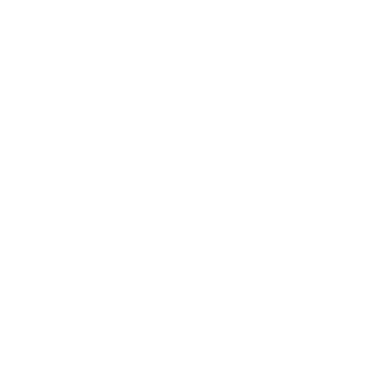

In [86]:
dep = get_vectorfile_ign(
  level = "DEPARTEMENT", field = "metropole",
  source = "COG", provider="opendatarchives")
dep['count_stations'] = df_visu_inst.groupby('Code Officiel Département').id.count()
ax = dep.plot(column = "count_stations")
ax.set_axis_off()

In [87]:
dep

,ID,NOM_M,NOM,INSEE_DEP,INSEE_REG,geometry,count_stations
0,DEPARTEM_FXX_00000000001,AIN,Ain,01,84,"POLYGON ((838383.200 6570485.800, 838483.800 6...",NaN
1,DEPARTEM_FXX_00000000002,AISNE,Aisne,02,32,"POLYGON ((708719.000 6956305.000, 708718.700 6...",NaN
2,DEPARTEM_FXX_00000000003,CORSE-DU-SUD,Corse-du-Sud,2A,94,"MULTIPOLYGON (((1165315.300 6103089.200, 11653...",NaN
3,DEPARTEM_FXX_00000000004,HAUTE-CORSE,Haute-Corse,2B,94,"MULTIPOLYGON (((1222168.900 6235253.100, 12221...",NaN
4,DEPARTEM_FXX_00000000005,ALLIER,Allier,03,84,"POLYGON ((664478.800 6602292.500, 664503.600 6...",NaN
...,...,...,...,...,...,...,...
91,DEPARTEM_FXX_00000000092,ESSONNE,Essonne,91,11,"POLYGON ((629444.100 6836670.800, 629365.600 6...",NaN
92,DEPARTEM_FXX_00000000093,HAUTS-DE-SEINE,Hauts-de-Seine,92,11,"POLYGON ((642868.900 6869240.500, 642874.900 6...",NaN
93,DEPARTEM_FXX_00000000094,SEINE-SAINT-DENIS,Seine-Saint-Denis,93,11,"POLYGON ((660415.900 6872923.300, 660423.700 6...",NaN
94,DEPARTEM_FXX_00000000095,VAL-DE-MARNE,Val-de-Marne,94,11,"POLYGON ((650731.000 6857288.700, 650942.200 6...",NaN


TypeError: no numeric data to plot

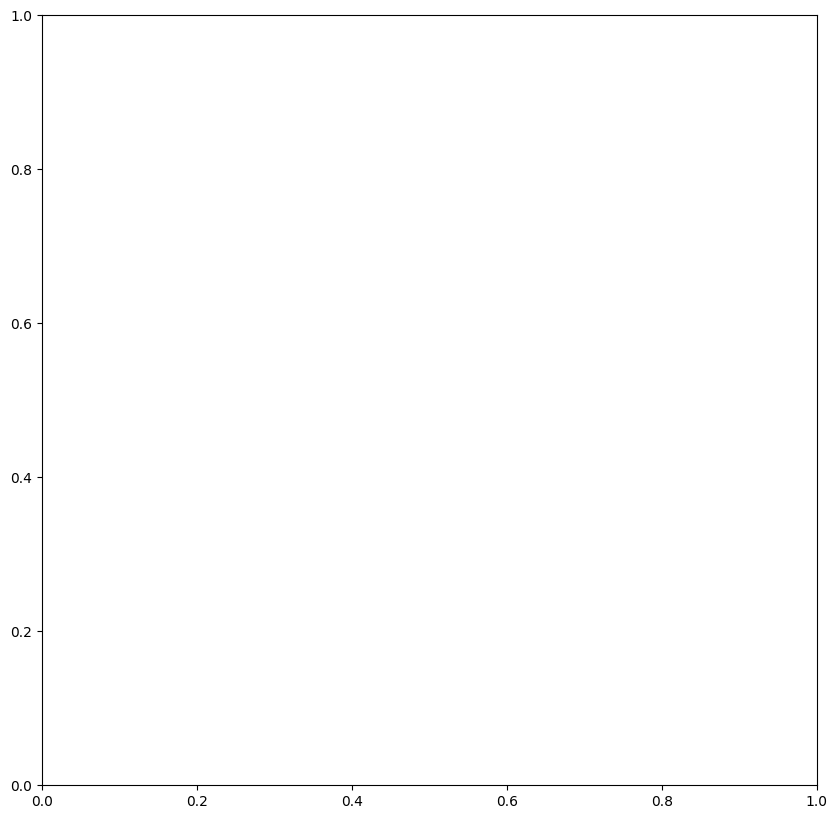

In [71]:
fig,ax = plt.subplots(figsize=(10, 10))
df_visu_inst.groupby('Code Officiel Département').plot(ax = ax, column = "id")
ax.set_axis_off()
ax

Pour savoir le nombre de stations que l'on va proposer à l'usager on regarde le nombre de stations autour de l'usager en fonction de la distance. 

In [60]:
def nb_station(df,Adresse, rayon) : #calcul de nb de station dans un rayon spécifié
    n=0
    position= md.Adresse_to_gps(Adresse)
    A = list(map(float,position.split(',')))
    for station in range(len(df)) : 
        B = list(map(float,df.iloc[station,2].split(',')))
        D=md.distanceGPS(A,B)
        if D<rayon : 
            n=n+1
    return n 

print(nb_station(df_visu_inst, "1 rue d'Arsonval, Orsay, France", 20000))

1


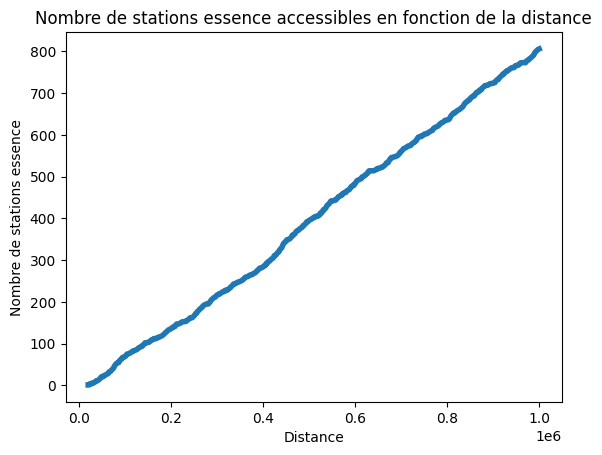

In [61]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(20000, 1000000, 500)
y=[]

for l in range(len(x)) : #prend 7min !
    y.append(nb_station(df_visu_inst, "1 rue d'Arsonval, Orsay, France", x[l]))

plt.plot(x, y, linewidth=4)
plt.xlabel("Distance")
plt.ylabel("Nombre de stations essence")
plt.title("Nombre de stations essence accessibles en fonction de la distance")


plt.show()

In [14]:
#calcul du prix du carburant par département

df_moy=df_visu
df_tst=df_moy.sample(200)

Prix_moy_dep=df_tst.groupby('Code Officiel Département')['prix_valeur'].mean()

Df_tstf= df_tst.merge(Prix_moy_dep, how='outer', on=['Code Officiel Département'] )
